In [103]:
# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# Import torchvision
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchmetrics

#Import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [121]:
# write device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"
print('Using {} device'.format(device))

Using cpu device


In [122]:
from PIL import Image


def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [123]:
### Get a dataset fashion MNIST

# Setup Training data

train_data = datasets.FashionMNIST(
    root = 'tf-knugs/datasets',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'tf-knugs/datasets',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)



In [124]:
# Setup data loaders
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset= train_data,
    batch_size = BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset= test_data,
    batch_size= BATCH_SIZE,
    shuffle= True
)

In [125]:
print(f"DataLoaders:{train_dataloader, test_dataloader} ")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders:(<torch.utils.data.dataloader.DataLoader object at 0x7f2d3d0929d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f2d3d3a1310>) 
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [126]:
print(len(train_data))
print(len(train_dataloader)*BATCH_SIZE)

60000
60000


In [127]:
#Check out whats inside the training data loader

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [128]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(-0.5, 27.5, 27.5, -0.5)

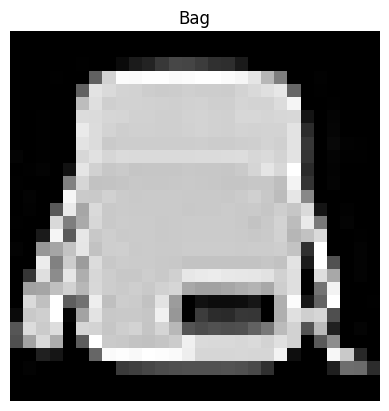

In [129]:
# show sample
# torch.manual_seed(42)
class_names = train_data.classes
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)


In [130]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [131]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0.to(device) # keep model on CPU to begin with

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [132]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Creating a function to time our expiriment

Machine learning is very expirimental.

Two main things we want ot keep track of is:
1. Model's performance (loss, acc)etc
2. Models spped or how fast it runs

In [133]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [134]:

def print_shape_device(*args):
    """
    This function prints the shape, data type and device of the given tensors or numpy arrays.

    Parameters:
    *args (torch tensor or numpy array): Variable length argument list of tensors or arrays.

    Returns:
    None
    """
    for arg in args:
        if torch.is_tensor(arg):
            print(f"Shape: {arg.shape} | Device: {arg.device}| Type : {arg.dtype} | torch tensor")
        elif isinstance(arg, np.ndarray):
            print(f"Shape: {arg.shape} | Device: CPU | Type : {arg.dtype} | numpy array")
        else:
            print("Input type not supported. Please provide a torch tensor or a numpy array.")

### Creating a training loop and trainin a model pn batches of data

1. Loop throung epoch.
2. Loop through training batches, perform training steps , calculate the train loss *per batch*.
3. Loop through testing batches, perform tetsing steps, claculate the test loos *per batch*.
4. Print out whats happening.
5. Time is all (for analytics and fun).

In [135]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()


# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.51016, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47435 | Test loss: 0.52677, Test acc: 81.68%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45367 | Test loss: 0.51264, Test acc: 83.00%

Train time on cpu: 30.840 seconds


In [136]:
# make predicitions and get model results

def eval_model(model: torch.nn.Module,
               dataloader: DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn
):
    """Returns a dictonary condataining prediciton parameter of a module

    Args:
        model (torch.nn.Module): model to evaluate
        dataloader (DataLoader): a dataloader that loads data by batches
        loss_fn (torch.nn.Module): function that calculates loss
        accuracy_fn (_type_): function that claculates accuracy
    """
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            # Make predicitons
            y_pred = model(X)

            # Accumulate the loss and accuracy values
            acc += accuracy_fn(y_true= y, y_pred= y_pred.argmax(dim=1))
            loss = loss_fn(y_pred, y)

        #Scale loss and acc to find the average loss/acc per batch
        loss /= len(dataloader)
        acc /= len(dataloader)

    return {
        "model_name" : model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc
    }

In [137]:
# Use the function to calculate
model0_results = eval_model(
    model=model_0,
    dataloader= test_dataloader,
    accuracy_fn= accuracy_fn,
    loss_fn= loss_fn
)
print(model0_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.0010662442073225975, 'model_acc': 83.00718849840256}
